# Determine whether an image contains a columnar cactus using Convolutional Neural Network (CNN) with Pytorch

### Writer: Amrik Singh
<i class="fa fa-linkedin" style="font-size:20px"></i>&nbsp;
[linkedin.com/in/amrik220/](https://www.linkedin.com/in/amrik220/)&emsp;
<i class="fa fa-github" style="font-size:20px"></i>&nbsp;
[github.com/amrik220](https://github.com/amrik220)

***

# Introduction

This notebook contains Python code to determine whether an image contains a columnar cactus or not using Convolutional Neural Network (CNN) with Pytorch. The dataset is from [Aerial Cactus Identification, a Kaggle Competition](https://www.kaggle.com/c/aerial-cactus-identification/overview). The dataset can be download from [here](https://www.kaggle.com/c/aerial-cactus-identification/data) and has following files:
1. train: training set of 17,500 (32 x 32) thumbnails
2. train.csv: training set lables, positive class has_cactus = 1

For the purpose of this task, the train dataset will be split into train (.64), validation (.16), test (.2) sets.

Programming Environment: Python 3.7.6 and Google Colaboratory

In [22]:
%%html
<h1>Introduction</h1>
<marquee style='width: 50%; color: green;'><b>Use it wisely!</b></marquee>

# Set up environment and explore data

In [23]:
# Display output of all code lines in Jupyter notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

!python --version # Check python version
!jupyter-notebook --version

Python 3.6.9
5.2.2


## Import required libraries and functions

In [24]:
# Import required libraries and functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
from skimage.io import imread
%matplotlib inline
from tqdm import tqdm

import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [25]:
# Clone the GitHub respository containing the data files to Colaboratory
import os
if os.path.exists('/content/imageProcessing') == False:
  !git clone https://github.com/amrik220/imageProcessing

In [26]:
# load data labels from the csv file
path = '/content/imageProcessing/aerial_cactus_identification/'
labels = pd.read_csv(path + 'train.csv')

labels.head()
labels.shape

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


(17500, 2)

In [27]:
# check class balance
table = labels.has_cactus.value_counts()
table
not_cactus = table[0]
cactus = table[1]

text = "\n\nPercentage of cactus: {:.2f}\nPercentage of not_cactus: {:.2f}"
print(text.format(cactus/(cactus+not_cactus)*100, not_cactus/(cactus+not_cactus)*100))

1    13136
0     4364
Name: has_cactus, dtype: int64



Percentage of cactus: 75.06
Percentage of not_cactus: 24.94


**Preview images containing cactus**

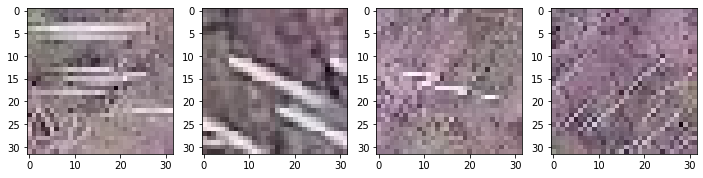

In [28]:
fig,ax = plt.subplots(nrows=1,ncols=4, figsize=(12,3))
for i,idx in enumerate(labels[labels['has_cactus'] == 1]['id'][0:4]):
    img_path = os.path.join(path,'train', idx)
    # print(img_path)
    ax[i].imshow(img.imread(img_path))

**Preview images not containing cactus**

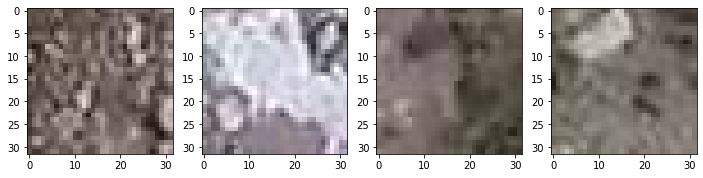

In [29]:
fig,ax = plt.subplots(nrows=1,ncols=4, figsize=(12,3))
for i,idx in enumerate(labels[labels['has_cactus'] == 0]['id'][0:4]):
    img_path = os.path.join(path,'train', idx)
    # print(img_path)
    ax[i].imshow(img.imread(img_path))

## Load images

In [30]:
# load training set images
data_img = []
for img_name in tqdm(labels.id):
    img_path = os.path.join(path,'train', img_name)
    # img = imread(img_path) 
    # normalize the pixel values
    # img /= 255.0
    img = imread(img_path, as_gray=True) # Keep only gray scale
    # convert the type of pixel to float 32
    img = img.astype('float32')
    data_img.append(img)

# convert the list to a numpy array
data_x = np.array(data_img)
# get target variable
data_y = labels.has_cactus.values
data_x.shape

100%|██████████| 17500/17500 [00:07<00:00, 2210.14it/s]


(17500, 32, 32)

In [31]:
data_x.min()
data_x.max()

0.0

1.0

In [32]:
data_x.dtype

dtype('float32')

# Preprocessing

Split the dataset in the training, validation, and test sets.

In [33]:
# Split the dataset in the training, validation, and test sets.

train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size = 0.2, random_state=220)

train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size = 0.2, random_state=220)

(train_x.shape, train_y.shape), (val_x.shape, val_y.shape), (test_x.shape, test_y.shape)

(((11200, 32, 32), (11200,)),
 ((2800, 32, 32), (2800,)),
 ((3500, 32, 32), (3500,)))

Convert data to torch format

In [34]:
# convert training images into torch format
train_x = train_x.reshape(11200, 1, 32, 32)
train_x  = torch.from_numpy(train_x)

# convert the target into torch format
train_y = train_y.astype(int);
train_y = torch.from_numpy(train_y)

# shape of training data
train_x.shape, train_y.shape

(torch.Size([11200, 1, 32, 32]), torch.Size([11200]))

In [35]:
# convert validation images into torch format
val_x = val_x.reshape(2800, 1, 32, 32)
val_x  = torch.from_numpy(val_x)

# convert the target into torch format
val_y = val_y.astype(int);
val_y = torch.from_numpy(val_y)

# shape of validation data
val_x.shape, val_y.shape

(torch.Size([2800, 1, 32, 32]), torch.Size([2800]))

In [36]:
# convert test images into torch format
test_x = test_x.reshape(3500, 1, 32, 32)
test_x  = torch.from_numpy(test_x)

# convert the target into torch format
test_y = test_y.astype(int);
test_y = torch.from_numpy(test_y)

# shape of testing data
test_x.shape, test_y.shape

(torch.Size([3500, 1, 32, 32]), torch.Size([3500]))

# Build CNN

In [37]:
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )
        self.linear_layers = Sequential(
            Linear(4 * 8 * 8, 10)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [38]:
# defining the model
model = Net()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.01)
# defining the loss function
criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=256, out_features=10, bias=True)
  )
)


# Train the model

In [39]:
def train(epoch):
    model.train()
    tr_loss = 0
    # get the training set
    x_train, y_train = Variable(train_x), Variable(train_y)
    # get the validation set
    x_val, y_val = Variable(val_x), Variable(val_y)
    # convert the data into GPU format
    if torch.cuda.is_available():
        x_train = x_train.cuda()
        y_train = y_train.cuda()
        x_val = x_val.cuda()
        y_val = y_val.cuda()

    # clear the Gradients of the model parameters
    optimizer.zero_grad()
    
    # prediction for training and validation set
    output_train = model(x_train)
    output_val = model(x_val)

    # comput the training and validation loss
    loss_train = criterion(output_train, y_train)
    loss_val = criterion(output_val, y_val)
    train_losses.append(loss_train)
    val_losses.append(loss_val)

    # comput the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    if epoch%2 == 0:
        # print the validation loss
        print('Epoch : ',epoch+1, '\t', 'validation loss :', loss_val)

In [40]:
# defining the number of epochs
n_epochs = 35
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []
# training the model
for epoch in range(n_epochs):
    train(epoch)

Epoch :  1 	 validation loss : tensor(1.5880, grad_fn=<NllLossBackward>)
Epoch :  3 	 validation loss : tensor(0.4108, grad_fn=<NllLossBackward>)
Epoch :  5 	 validation loss : tensor(0.3160, grad_fn=<NllLossBackward>)
Epoch :  7 	 validation loss : tensor(0.2799, grad_fn=<NllLossBackward>)
Epoch :  9 	 validation loss : tensor(0.2546, grad_fn=<NllLossBackward>)
Epoch :  11 	 validation loss : tensor(0.2331, grad_fn=<NllLossBackward>)
Epoch :  13 	 validation loss : tensor(0.2129, grad_fn=<NllLossBackward>)
Epoch :  15 	 validation loss : tensor(0.1939, grad_fn=<NllLossBackward>)
Epoch :  17 	 validation loss : tensor(0.1770, grad_fn=<NllLossBackward>)
Epoch :  19 	 validation loss : tensor(0.1666, grad_fn=<NllLossBackward>)
Epoch :  21 	 validation loss : tensor(0.1596, grad_fn=<NllLossBackward>)
Epoch :  23 	 validation loss : tensor(0.1496, grad_fn=<NllLossBackward>)
Epoch :  25 	 validation loss : tensor(0.1404, grad_fn=<NllLossBackward>)
Epoch :  27 	 validation loss : tensor(0.13

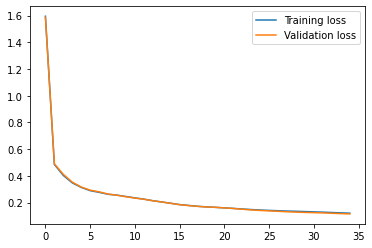

In [41]:
# plot the training and validation loss
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

# Prediction

In [42]:
# prediction for training set
with torch.no_grad():
    output = model(train_x)
    
softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)
# accuracy on training 
acc_train = accuracy_score(train_y, predictions)*100
print("Training accuracy: {:.2f}".format(acc_train))

Training accuracy: 95.48


In [43]:
# prediction for validation set
with torch.no_grad():
    output = model(val_x)

softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)
# accuracy on validation 
acc_val = accuracy_score(val_y, predictions)*100
print("Training accuracy: {:.2f}".format(acc_val))

Training accuracy: 95.89


In [44]:
# prediction for test set
with torch.no_grad():
    output = model(test_x)

softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)
# accuracy on test 
acc_test = accuracy_score(test_y, predictions)*100
print("Training accuracy: {:.2f}".format(acc_test))

Training accuracy: 95.74


# References
1. https://www.kaggle.com/c/aerial-cactus-identification/data
2. https://www.pluralsight.com/guides/image-classification-with-pytorch
3. https://www.analyticsvidhya.com/blog/2019/10/building-image-classification-models-cnn-pytorch/
